In [ ]:
%tensorflow_version 2.x
# from tqdm import tqdm

In [ ]:
!wget https://www.cs.ucsb.edu/~william/data/liar_dataset.zip -q --show-progress
!unzip 'liar_dataset.zip' -d LIAR_dataset
!wget https://raw.githubusercontent.com/saurav9878/Fake-News-Detection/master/Clean_Texts.py -q --show-progress
!wget https://raw.githubusercontent.com/saurav9878/Fake-News-Detection/master/AttentionLayer.py -q --show-progress
!mkdir plots

liar_dataset.zip    100%[===================>] 989.82K  1.58MB/s    in 0.6s    
Archive:  liar_dataset.zip
  inflating: LIAR_dataset/README     
  inflating: LIAR_dataset/test.tsv   
  inflating: LIAR_dataset/train.tsv  
  inflating: LIAR_dataset/valid.tsv  
Clean_Texts.py      100%[===================>]   2.37K  --.-KB/s    in 0s      
AttentionLayer.py   100%[===================>]   1.56K  --.-KB/s    in 0s      


In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
import sys
import os
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
#from keras.layers import Merge
#replaced by
from keras.layers import add

# NLTK import, download
import nltk
from nltk import tokenize # used only for splitting data into words, sentences
nltk.download(['punkt', 'stopwords'], quiet=True)

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [ ]:
#import my modules
from Clean_Texts import clean_text
from AttentionLayer import AttLayer

In [ ]:
def read_data(filename):
    df = pd.read_csv(filename,engine='python', delimiter=r'\t+', names=['id', 'Label','Statement', 'subject', 'speaker','speaker_title','state', 'party','barely_true','false_counts','half_true','mostly_true','pants_on_fire','context'])
    labels=[]
    for l in df['Label']:
        if l in ['false','barely-true','pants-fire']:
            labels.append(1)
        elif l in ['half-true','mostly-true', 'true']:
            labels.append(0)
        else:
            raise Exception("Error encountered in labelling")
    data = pd.concat([df['Statement'], pd.Series(labels)], axis=1)
    data.columns = ['Statement', 'Label']
    return data

In [ ]:
data_train = read_data('LIAR_dataset/train.tsv')
data_test = read_data('LIAR_dataset/test.tsv')
# data_valid = read_data('LIAR_dataset/valid.tsv') # not using currently valid tsv

train_labels = np.asarray(data_train['Label'])
test_labels = np.asarray(data_test['Label'])

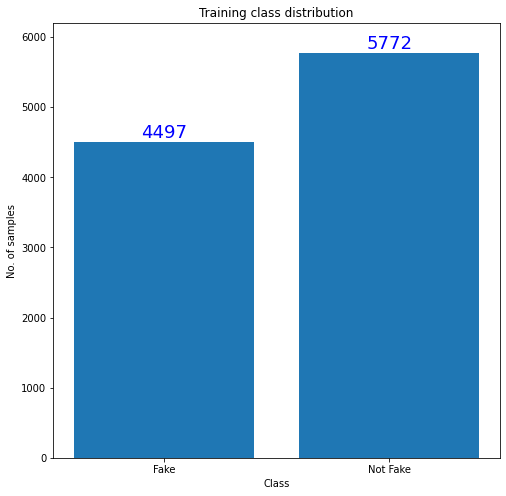

In [ ]:
y_tr = [sum(train_labels), len(train_labels) - sum(train_labels)]
x_tr = ["Fake", "Not Fake"]
plt.figure(figsize=(8,8))
plt.bar(x_tr,y_tr)
for i in range(2):
    plt.text(x_tr[i], y_tr[i]+60, str(y_tr[i]),ha='center', color='blue', fontsize=18)
plt.ylim(top=6200)
plt.xlabel('Class')
plt.ylabel('No. of samples')
plt.title('Training class distribution')
plt.rcParams.update({'font.size': 21})
plt.savefig('plots/train_class_dist.png')

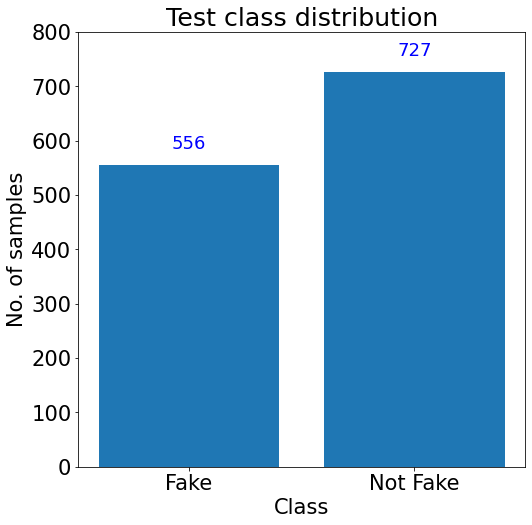

In [ ]:
y_tr = [sum(test_labels), len(test_labels) - sum(test_labels)]
x_tr = ["Fake", "Not Fake"]
plt.figure(figsize=(8,8))
plt.bar(x_tr,y_tr)
for i in range(2):
    plt.text(x_tr[i], y_tr[i]+30, str(y_tr[i]),ha='center', color='blue', fontsize=18)
plt.ylim(top=800)
plt.xlabel('Class')
plt.ylabel('No. of samples')
plt.title('Test class distribution')
plt.rcParams.update({'font.size': 18})
plt.savefig('plots/test_class_dist.png')

In [ ]:
# ! pip install transformers
import transformers
dbert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased',)
dbert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
small_train = data_train.Statement.iloc[:10]
train_tokenized = small_train.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True, max_length=128, padding='max_length')))

In [ ]:
input_tokens=[]
for x in train_tokenized:
    input_tokens.append(x)

input_tokens = np.asarray(input_tokens)
input_tokens.shape

(10, 128)

In [ ]:
output_tokens = dbert_model(input_tokens)

In [ ]:
output_tokens.shape

AttributeError: ignored

In [ ]:
# from transformers import pipeline
# feature_pipeline = pipeline('feature-extraction', model=dbert_model, tokenizer=dbert_tokenizer(max_length=20, add_special_tokens=True,padding='max-length'), framework='tf')

In [ ]:
# import numpy as np
# np.asarray(feature_pipeline('Hello World', max_length =2)).shape

In [ ]:
# feature_extracted = feature_pipeline(list(data_train.Statement)[:10])

In [ ]:
test_tokenized = data_test.Statement.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True, max_length=128, padding='max_length')))
input_test_tokens=[]
for x in test_tokenized:
    input_test_tokens.append(x)

input_test_tokens = np.asarray(input_test_tokens)

test_features = dbert_model(input_test_tokens)

In [ ]:
test_features = np.asarray(test_features)


In [ ]:
features_array = np.asarray(feature_extracted)
features_array.shape # (Samples, Tokens, Vector Size)

(10, 39, 768)

In [ ]:
MAX_TOKENS = 128

In [ ]:
# features = np.squeeze(features_array)
# features = features[:,0,:]
# features.shape

In [ ]:
import tensorflow as tf

In [ ]:
labels = train_labels[:10]
labels = labels.reshape(-1,1)
data = output_tokens

In [ ]:
test_labels

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
VALIDATION_SPLIT=0.2

In [ ]:
data[0].numpy()

array([[[ 0.22226833, -0.31437734,  0.24113639, ..., -0.00480534,
          0.6010438 , -0.10481428],
        [ 0.02030095,  0.19371276,  0.42124563, ..., -0.0740913 ,
          0.12858337, -0.32375836],
        [-0.5301106 , -0.17019545,  0.01300799, ...,  0.12206502,
          0.50405145, -0.36402282],
        ...,
        [ 0.7547754 , -0.11936335,  0.62505776, ..., -0.17448005,
          0.44121945, -0.24639218],
        [ 0.76379913, -0.11564641,  0.63993233, ..., -0.17067736,
          0.4385281 , -0.32272103],
        [ 0.7765223 , -0.13505608,  0.58175206, ..., -0.16163233,
          0.44357356, -0.37658492]],

       [[ 0.00865666, -0.24939358,  0.14415844, ...,  0.03816395,
          0.5942589 , -0.02954666],
        [-0.7563773 ,  0.00731454,  0.42165786, ..., -0.15993744,
         -0.18487403, -0.22828689],
        [-0.14651403, -0.44060132,  0.0674536 , ..., -0.4292241 ,
          0.26770532, -0.4543556 ],
        ...,
        [ 0.6876758 , -0.12860401,  0.6669642 , ..., -

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data[0].numpy(),
                                                    labels,
                                                    test_size=0.5,
                                                    random_state=1)

In [ ]:
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

In [ ]:
#customized f1 score function for passing into model metrics:
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
embedded_sequences = Input(shape=(MAX_TOKENS,768,), dtype='float32')
c=Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu')(embedded_sequences)
maxPool=MaxPooling1D(pool_size=2)(c)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(maxPool)
l_att = AttLayer(100)(l_lstm)
preds = Dense(1, activation='sigmoid')(l_att)
model_Att = Model(embedded_sequences, preds)
model_Att.summary()

from keras.utils.vis_utils import plot_model
plot_model(model_Att, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

model_Att.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',F1_Score,])
history = model_Att.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=50, batch_size=32)

# score=model_Att.evaluate(x_test,y_test,verbose=1)
# print('Test Accuracy: '+str(score[1]))
# print('Test F1 Score: '+str(score[2]))

# from sklearn.metrics import precision_recall_fscore_support,classification_report
# y_pred=model_Att.predict(x_test)
# #print(y_pred)
# y2=[]
# for q in y_pred:
#   if(q[0]>0.5):
#     y2.append(True)
#   else:
#     y2.append(False)
# print('Classification report:\n',classification_report(y_test,y2))
# #print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
# #print(y_pred)

tracking <tf.Variable 'att_layer_3/Variable:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_3/Variable:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_3/Variable:0' shape=(100, 1) dtype=float32> u
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 768)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 126, 128)          295040    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 63, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 63, 200)           137400    
_________________________________________________________________
att_layer_3 (AttLayer)       (None, 200)               20200     
____________________

In [ ]:
score=model_Att.evaluate(test_features[0].numpy(),test_labels,verbose=1)
print('Test Accuracy: '+str(score[1]))
print('Test F1 Score: '+str(score[2]))

from sklearn.metrics import precision_recall_fscore_support,classification_report
y_pred=model_Att.predict(test_features[0].numpy())
#print(y_pred)
y2=[]
for q in y_pred:
  if(q[0]>0.5):
    y2.append(True)
  else:
    y2.append(False)
print('Classification report:\n',classification_report(test_labels,y2))
#print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
#print(y_pred)

1283/1283 [==============================] - 3s 2ms/step
Test Accuracy: 0.5479345321655273
Test F1 Score: 0.24351564049720764
Classification report:
               precision    recall  f1-score   support

           0       0.57      0.82      0.67       727
           1       0.45      0.19      0.27       556

    accuracy                           0.55      1283
   macro avg       0.51      0.51      0.47      1283
weighted avg       0.52      0.55      0.50      1283



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y2)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[596 131]
 [449 107]]


dict_keys(['val_loss', 'val_accuracy', 'val_F1_Score', 'loss', 'accuracy', 'F1_Score'])


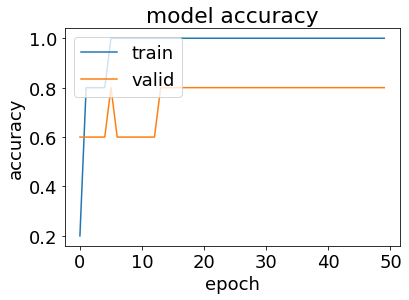

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.show()
plt.savefig('plots/Model_accuracy.png')

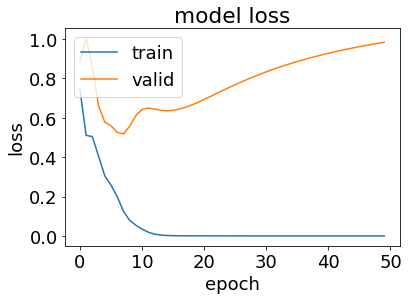

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.show()
plt.savefig('plots/Model_loss.png')